In [1]:
TRAIN_PATH = "CovidDataset1/Train"
VAL_PATH = "CovidDataset1/Val"
TEST_PATH = "CovidDataset1/test"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.applications.vgg19 import VGG19
from keras.layers import *
from keras.models import * 
from keras.preprocessing import image

In [3]:
from keras.metrics import *

METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
]

In [4]:
import keras
def create_model():

    # add preprocessing layer to the front of VGG
    vgg = VGG19(input_shape=(224,224,3), weights='imagenet', include_top=False)

    # don't train existing weights
    for layer in vgg.layers:
      layer.trainable = False
    
    # our layers - you can add more if you want
    x = Flatten()(vgg.output)
    x = Dense(220, activation='relu')(x)
    x = Dropout(0.1)(x)
    prediction = Dense(1, activation='sigmoid')(x)

    # create a model object
    model = Model(inputs=vgg.input, outputs=prediction)
    model.compile(loss=keras.losses.binary_crossentropy,optimizer='adam',metrics=METRICS)
    return model


In [5]:
model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
# Train from scratch
train_datagen = image.ImageDataGenerator(
#     rescale = 1./255,
#     shear_range = 0.2,
#     zoom_range = 0.2,
#     horizontal_flip = True,
)

test_dataset = image.ImageDataGenerator()

In [7]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary')

Found 8764 images belonging to 2 classes.


In [8]:
validation_generator = test_dataset.flow_from_directory(
    VAL_PATH,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary')

Found 2150 images belonging to 2 classes.


In [9]:
test_generator = test_dataset.flow_from_directory(
    TEST_PATH,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary')

Found 800 images belonging to 2 classes.


In [10]:
train_generator.class_indices

{'Covid': 0, 'Negative': 1}

In [11]:
import os
from keras.callbacks import ModelCheckpoint,EarlyStopping, CSVLogger
checkpoint_path = "vgg19/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', verbose=1,save_weights_only=True,save_best_only=True, mode='auto')
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
log_csv = CSVLogger('vgg19/vgg19.csv', separator=',', append=False)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5)

callbacks_list = [checkpoint,reduce_lr, log_csv]


In [12]:
from keras.callbacks import ModelCheckpoint

hist = model.fit(
    train_generator,
   steps_per_epoch=len(train_generator),
    epochs = 100,
    validation_data = validation_generator,
    validation_steps=len(validation_generator),
    callbacks=callbacks_list    
)

Epoch 1/100
274/274 [==============================] - 72s 237ms/step - loss: 1.3945 - tp: 4629.0000 - fp: 416.0000 - tn: 3265.0000 - fn: 454.0000 - accuracy: 0.9007 - precision: 0.9175 - recall: 0.9107 - val_loss: 0.0890 - val_tp: 1684.0000 - val_fp: 23.0000 - val_tn: 391.0000 - val_fn: 52.0000 - val_accuracy: 0.9651 - val_precision: 0.9865 - val_recall: 0.9700

Epoch 00001: val_loss improved from inf to 0.08902, saving model to vgg19\cp-0001.ckpt
Epoch 2/100
274/274 [==============================] - 59s 214ms/step - loss: 0.0912 - tp: 4923.0000 - fp: 148.0000 - tn: 3533.0000 - fn: 160.0000 - accuracy: 0.9649 - precision: 0.9708 - recall: 0.9685 - val_loss: 0.1143 - val_tp: 1700.0000 - val_fp: 49.0000 - val_tn: 365.0000 - val_fn: 36.0000 - val_accuracy: 0.9605 - val_precision: 0.9720 - val_recall: 0.9793

Epoch 00002: val_loss did not improve from 0.08902
Epoch 3/100
274/274 [==============================] - 58s 213ms/step - loss: 0.0598 - tp: 4951.0000 - fp: 91.0000 - tn: 3590.0000


Epoch 00020: val_loss did not improve from 0.08059
Epoch 21/100
274/274 [==============================] - 58s 213ms/step - loss: 0.0056 - tp: 5081.0000 - fp: 21.0000 - tn: 3660.0000 - fn: 2.0000 - accuracy: 0.9974 - precision: 0.9959 - recall: 0.9996 - val_loss: 0.2004 - val_tp: 1718.0000 - val_fp: 65.0000 - val_tn: 349.0000 - val_fn: 18.0000 - val_accuracy: 0.9614 - val_precision: 0.9635 - val_recall: 0.9896

Epoch 00021: val_loss did not improve from 0.08059
Epoch 22/100
274/274 [==============================] - 58s 213ms/step - loss: 0.0055 - tp: 5076.0000 - fp: 15.0000 - tn: 3666.0000 - fn: 7.0000 - accuracy: 0.9975 - precision: 0.9971 - recall: 0.9986 - val_loss: 0.1953 - val_tp: 1720.0000 - val_fp: 72.0000 - val_tn: 342.0000 - val_fn: 16.0000 - val_accuracy: 0.9591 - val_precision: 0.9598 - val_recall: 0.9908

Epoch 00022: val_loss did not improve from 0.08059
Epoch 23/100
274/274 [==============================] - 59s 214ms/step - loss: 0.0049 - tp: 5082.0000 - fp: 17.0000 - 


Epoch 00040: val_loss did not improve from 0.08059
Epoch 41/100
274/274 [==============================] - 59s 213ms/step - loss: 0.0049 - tp: 5081.0000 - fp: 17.0000 - tn: 3664.0000 - fn: 2.0000 - accuracy: 0.9978 - precision: 0.9967 - recall: 0.9996 - val_loss: 0.2268 - val_tp: 1715.0000 - val_fp: 65.0000 - val_tn: 349.0000 - val_fn: 21.0000 - val_accuracy: 0.9600 - val_precision: 0.9635 - val_recall: 0.9879

Epoch 00041: val_loss did not improve from 0.08059
Epoch 42/100
274/274 [==============================] - 58s 213ms/step - loss: 0.0041 - tp: 5082.0000 - fp: 16.0000 - tn: 3665.0000 - fn: 1.0000 - accuracy: 0.9981 - precision: 0.9969 - recall: 0.9998 - val_loss: 0.2299 - val_tp: 1715.0000 - val_fp: 65.0000 - val_tn: 349.0000 - val_fn: 21.0000 - val_accuracy: 0.9600 - val_precision: 0.9635 - val_recall: 0.9879

Epoch 00042: val_loss did not improve from 0.08059
Epoch 43/100
274/274 [==============================] - 59s 214ms/step - loss: 0.0037 - tp: 5082.0000 - fp: 13.0000 - 


Epoch 00060: val_loss did not improve from 0.08059
Epoch 61/100
274/274 [==============================] - 58s 213ms/step - loss: 0.0054 - tp: 5076.0000 - fp: 18.0000 - tn: 3663.0000 - fn: 7.0000 - accuracy: 0.9971 - precision: 0.9965 - recall: 0.9986 - val_loss: 0.2413 - val_tp: 1719.0000 - val_fp: 68.0000 - val_tn: 346.0000 - val_fn: 17.0000 - val_accuracy: 0.9605 - val_precision: 0.9619 - val_recall: 0.9902

Epoch 00061: val_loss did not improve from 0.08059
Epoch 62/100
274/274 [==============================] - 58s 213ms/step - loss: 0.0046 - tp: 5081.0000 - fp: 17.0000 - tn: 3664.0000 - fn: 2.0000 - accuracy: 0.9978 - precision: 0.9967 - recall: 0.9996 - val_loss: 0.2411 - val_tp: 1719.0000 - val_fp: 68.0000 - val_tn: 346.0000 - val_fn: 17.0000 - val_accuracy: 0.9605 - val_precision: 0.9619 - val_recall: 0.9902

Epoch 00062: val_loss did not improve from 0.08059
Epoch 63/100
274/274 [==============================] - 58s 212ms/step - loss: 0.0036 - tp: 5080.0000 - fp: 13.0000 - 


Epoch 00080: val_loss did not improve from 0.08059
Epoch 81/100
274/274 [==============================] - 59s 214ms/step - loss: 0.0042 - tp: 5078.0000 - fp: 11.0000 - tn: 3670.0000 - fn: 5.0000 - accuracy: 0.9982 - precision: 0.9978 - recall: 0.9990 - val_loss: 0.2419 - val_tp: 1719.0000 - val_fp: 68.0000 - val_tn: 346.0000 - val_fn: 17.0000 - val_accuracy: 0.9605 - val_precision: 0.9619 - val_recall: 0.9902

Epoch 00081: val_loss did not improve from 0.08059
Epoch 82/100
274/274 [==============================] - 58s 213ms/step - loss: 0.0034 - tp: 5082.0000 - fp: 11.0000 - tn: 3670.0000 - fn: 1.0000 - accuracy: 0.9986 - precision: 0.9978 - recall: 0.9998 - val_loss: 0.2419 - val_tp: 1719.0000 - val_fp: 68.0000 - val_tn: 346.0000 - val_fn: 17.0000 - val_accuracy: 0.9605 - val_precision: 0.9619 - val_recall: 0.9902

Epoch 00082: val_loss did not improve from 0.08059
Epoch 83/100
274/274 [==============================] - 59s 214ms/step - loss: 0.0043 - tp: 5081.0000 - fp: 17.0000 - 


Epoch 00100: val_loss did not improve from 0.08059


In [13]:
os.listdir(checkpoint_dir)

['checkpoint',
 'cp-0001.ckpt.data-00000-of-00001',
 'cp-0001.ckpt.index',
 'cp-0002.ckpt.data-00000-of-00001',
 'cp-0002.ckpt.index',
 'cp-0003.ckpt.data-00000-of-00001',
 'cp-0003.ckpt.index',
 'cp-0004.ckpt.data-00000-of-00001',
 'cp-0004.ckpt.index',
 'cp-0005.ckpt.data-00000-of-00001',
 'cp-0005.ckpt.index',
 'cp-0006.ckpt.data-00000-of-00001',
 'cp-0006.ckpt.index',
 'cp-0007.ckpt.data-00000-of-00001',
 'cp-0007.ckpt.index',
 'cp-0008.ckpt.data-00000-of-00001',
 'cp-0008.ckpt.index',
 'cp-0009.ckpt.data-00000-of-00001',
 'cp-0009.ckpt.index',
 'cp-0010.ckpt.data-00000-of-00001',
 'cp-0010.ckpt.index',
 'cp-0011.ckpt.data-00000-of-00001',
 'cp-0011.ckpt.index',
 'cp-0013.ckpt.data-00000-of-00001',
 'cp-0013.ckpt.index',
 'cp-0014.ckpt.data-00000-of-00001',
 'cp-0014.ckpt.index',
 'cp-0016.ckpt.data-00000-of-00001',
 'cp-0016.ckpt.index',
 'cp-0017.ckpt.data-00000-of-00001',
 'cp-0017.ckpt.index',
 'cp-0019.ckpt.data-00000-of-00001',
 'cp-0019.ckpt.index',
 'cp-0022.ckpt.data-00000

In [34]:
import tensorflow
latest = tensorflow.train.latest_checkpoint(checkpoint_dir)
latest

'vgg19\\cp-0004.ckpt'

In [15]:
# Create a basic model instance
model = create_model()

# Evaluate the model
results = model.evaluate_generator(validation_generator, 1)
print("The model has a {}% accuracy, with a loss of {}.".format(results[5]*100, results[0])) 


C:\Users\User\anaconda3\envs\TF-Gpu\lib\site-packages\keras\engine\training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


The model has a 95.09624242782593% accuracy, with a loss of 6.019331455230713.


In [16]:
# Create a new model instance
model = create_model()

# Load the previously saved weights
model.load_weights(latest)

results = model.evaluate_generator(validation_generator, 1)
print("The model has a {}% accuracy, with a loss of {}.".format(results[5]*100, results[0])) 


The model has a 95.16711831092834% accuracy, with a loss of 0.006337345112115145.


In [17]:
model.evaluate_generator(train_generator)

[0.013268825598061085,
 5059.0,
 16.0,
 3665.0,
 24.0,
 0.995435893535614,
 0.9968472719192505,
 0.9952783584594727]

In [18]:
model.evaluate_generator(validation_generator)

[0.08058653026819229,
 1713.0,
 54.0,
 360.0,
 23.0,
 0.9641860723495483,
 0.9694397449493408,
 0.986751139163971]

In [36]:
model.evaluate_generator(test_generator)

[0.15409362316131592,
 394.0,
 49.0,
 351.0,
 6.0,
 0.9312499761581421,
 0.8893905282020569,
 0.9850000143051147]

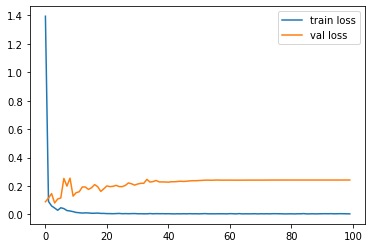

<Figure size 432x288 with 0 Axes>

In [20]:
# loss
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

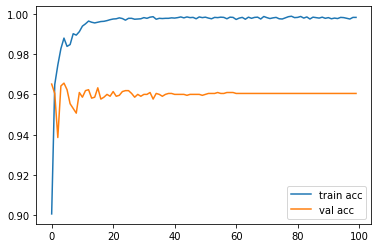

<Figure size 432x288 with 0 Axes>

In [21]:
# accuracies
plt.plot(hist.history['accuracy'], label='train acc')
plt.plot(hist.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [22]:
y_actual = []
y_test = []

In [23]:
import os
from keras.preprocessing import image
import numpy as np
for i in os.listdir("CovidDataset1/test/Negative/"):
   img = image.load_img("CovidDataset1/test/Negative/"+i, target_size= (224, 224));
   img = image.img_to_array(img)
   img = np.expand_dims(img, axis = 0)
   p = model.predict(img)
   classes_x=np.argmax(p,axis=0)
   y_test.append(p[0,0])
   y_actual.append(1)

In [24]:
for i in os.listdir("CovidDataset1/test/Covid/"):
   img = image.load_img("CovidDataset1/test/Covid/"+i, target_size= (224, 224));
   img = image.img_to_array(img)
   img = np.expand_dims(img, axis = 0)
   p = model.predict(img)
   classes_x=np.argmax(p,axis=0)
   y_test.append(p[0,0])
   y_actual.append(0)

In [25]:
y_actual = np.array(y_actual)
y_test = np.array(y_test)

In [26]:
print(y_actual)


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [27]:
print(y_test)

[3.97273719e-01 9.99717653e-01 9.99999285e-01 9.99784291e-01
 9.60415483e-01 9.96465445e-01 1.00000000e+00 9.99999404e-01
 9.99999881e-01 1.00000000e+00 9.99984264e-01 9.99999762e-01
 9.99985933e-01 9.99999642e-01 9.99999523e-01 9.99729693e-01
 9.99985695e-01 9.98562515e-01 9.99968529e-01 1.00000000e+00
 9.99958158e-01 9.99911904e-01 9.99992132e-01 9.91168141e-01
 9.98026788e-01 9.99914885e-01 9.99996305e-01 1.00000000e+00
 9.99981999e-01 9.99983072e-01 9.99999642e-01 9.99892354e-01
 9.95441794e-01 9.99999881e-01 9.99999762e-01 9.99996305e-01
 9.99655724e-01 9.99338329e-01 9.99904037e-01 8.67428958e-01
 9.99997616e-01 9.98400152e-01 9.99999762e-01 1.00000000e+00
 1.00000000e+00 9.99715388e-01 9.99996543e-01 1.00000000e+00
 9.99999642e-01 9.99999881e-01 9.99994278e-01 9.99984264e-01
 9.99999523e-01 1.00000000e+00 9.99493480e-01 9.99911785e-01
 9.93617773e-01 9.99997854e-01 1.00000000e+00 1.00000000e+00
 9.99997258e-01 9.99933362e-01 9.99999285e-01 9.99988914e-01
 1.00000000e+00 1.000000

In [28]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_actual, np.round(abs(y_test)))
cm

array([[351,  49],
       [  6, 394]], dtype=int64)

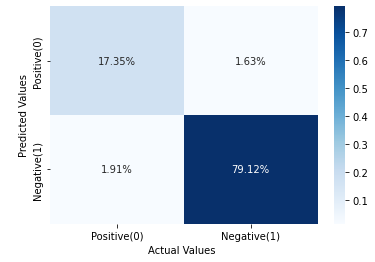

In [29]:
cm=[[373, 35],
     [ 41, 1701 ]]

import seaborn as sns

ax = sns.heatmap(cm/np.sum(cm), cmap = "Blues", fmt='.2%', annot=True)

ax.set_ylabel('\nPredicted Values')
ax.set_xlabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.yaxis.set_ticklabels(['Positive(0)','Negative(1)'])
ax.xaxis.set_ticklabels(['Positive(0)','Negative(1)'])

## Display the visualization of the Confusion Matrix.
plt.show()

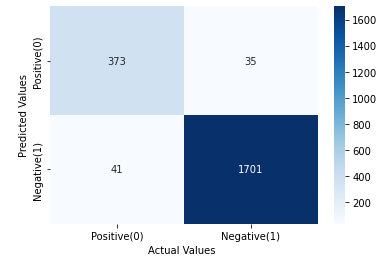

In [30]:
cm=[[373, 35],
     [ 41, 1701 ]]

import seaborn as sns

ax = sns.heatmap(cm, cmap = "Blues", annot=True, fmt=".0f")

ax.set_ylabel('\nPredicted Values')
ax.set_xlabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.yaxis.set_ticklabels(['Positive(0)','Negative(1)'])
ax.xaxis.set_ticklabels(['Positive(0)','Negative(1)'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [31]:
from sklearn.metrics import classification_report

print(classification_report(y_actual, np.round(abs(y_test))))


              precision    recall  f1-score   support

           0       0.98      0.88      0.93       400
           1       0.89      0.98      0.93       400

    accuracy                           0.93       800
   macro avg       0.94      0.93      0.93       800
weighted avg       0.94      0.93      0.93       800

